# Start

Winter Greenland δ¹⁸O ↔ NAO-like circulation (pressure pattern)

Summer Greenland δ¹⁸O ↔ temperature / SST-type variability (we only have T2m here, so we’ll do δ¹⁸O–T2m clearly for summer + annual, and circulation mainly for winter)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats import linregress
from sklearn.decomposition import PCA

In [3]:

# -------------------------
# 0) Small utilities
# -------------------------
def _mat_keys(mat):
    """Return user-facing keys (ignore MATLAB metadata)."""
    return [k for k in mat.keys() if not k.startswith("__")]


def load_first_matching(mat, candidates):
    """
    Try to load the first variable present in `candidates`.
    Returns the array and the key name.
    """
    for k in candidates:
        if k in mat:
            return mat[k], k
    raise KeyError(f"None of these keys found: {candidates}\nAvailable: {_mat_keys(mat)}")


def squeeze(a):
    return np.squeeze(np.array(a))


def standardize_lon(lon):
    """
    Convert longitudes to [-180, 180].
    """
    lon = squeeze(lon).astype(float)
    lon = ((lon + 180) % 360) - 180
    return lon


def area_weights(lat):
    """
    Cos(lat) weighting for area means on lat/lon grids.
    Returns shape (lat, 1) to broadcast with (lat, lon).
    """
    lat = squeeze(lat).astype(float)
    w = np.cos(np.deg2rad(lat))
    w = w / np.nanmean(w)  # normalize (not required but convenient)
    return w[:, None]


def subset_box(lat, lon, field, lat_min, lat_max, lon_min, lon_max):
    """
    Subset a lat/lon field to a rectangular box.
    Supports field shapes:
      - (time, lat, lon)
      - (lat, lon)
    """
    lat = squeeze(lat)
    lon = squeeze(lon)

    ilat = np.where((lat >= lat_min) & (lat <= lat_max))[0]
    ilon = np.where((lon >= lon_min) & (lon <= lon_max))[0]

    if field.ndim == 3:
        return lat[ilat], lon[ilon], field[:, ilat][:, :, ilon]
    elif field.ndim == 2:
        return lat[ilat], lon[ilon], field[ilat][:, ilon]
    else:
        raise ValueError(f"Unsupported field ndim={field.ndim}")


def area_mean(field_tlatlon, lat):
    """
    Area-weighted mean for (time, lat, lon).
    """
    w = area_weights(lat)  # (lat, 1)
    num = np.nansum(field_tlatlon * w[None, :, :], axis=(1, 2))
    den = np.nansum(np.isfinite(field_tlatlon) * w[None, :, :], axis=(1, 2))
    return num / den


def nearest_grid_point(lat, lon, target_lat, target_lon):
    """
    Return indices (ilat, ilon) of nearest grid point.
    """
    lat = squeeze(lat)
    lon = squeeze(lon)
    ilat = int(np.argmin(np.abs(lat - target_lat)))
    ilon = int(np.argmin(np.abs(lon - target_lon)))
    return ilat, ilon


def detrend_simple(x):
    """
    Remove linear trend. (Keeps it simple; works for correlations.)
    """
    t = np.arange(len(x))
    m, b = np.polyfit(t, x, 1)
    return x - (m * t + b)

In [4]:
# -------------------------
# 1) Load the .mat files
# -------------------------
def load_seasonal_mat(path):
    """
    Loads a .mat file expected to contain:
      lat, lon, (optionally) year/time,
      and three fields: jja, djf, annual (names vary).
    Returns dict with keys: lat, lon, years, jja, djf, annual
    """
    mat = loadmat(path)

    # Common coordinate key guesses
    lat, _ = load_first_matching(mat, ["lat", "latitude", "LAT", "Latitude"])
    lon, _ = load_first_matching(mat, ["lon", "longitude", "LON", "Longitude"])
    lat = squeeze(lat).astype(float)
    lon = standardize_lon(lon)

    # Time/year guesses (if missing, we just index 0..N-1)
    years = None
    for cand in ["year", "years", "time", "TIME", "Year"]:
        if cand in mat:
            years = squeeze(mat[cand]).astype(int)
            break

    # Seasonal fields guesses (very common naming patterns)
    jja, jja_k = load_first_matching(mat, ["jja", "JJA", "jja_mean", "JJA_mean"])
    djf, djf_k = load_first_matching(mat, ["djf", "DJF", "djf_mean", "DJF_mean"])
    ann, ann_k = load_first_matching(mat, ["annual", "ANN", "ann", "year_mean", "Annual"])

    jja = squeeze(jja).astype(float)
    djf = squeeze(djf).astype(float)
    ann = squeeze(ann).astype(float)

    # Ensure shapes are (time, lat, lon)
    # Sometimes MATLAB stores as (lat, lon, time)
    def ensure_tlatlon(a):
        if a.ndim != 3:
            raise ValueError(f"Expected 3D (time,lat,lon) but got shape {a.shape}")
        # Heuristic: if first dim equals lat length, it's probably (lat, lon, time)
        if a.shape[0] == len(lat) and a.shape[1] == len(lon):
            a = np.transpose(a, (2, 0, 1))
        return a

    jja = ensure_tlatlon(jja)
    djf = ensure_tlatlon(djf)
    ann = ensure_tlatlon(ann)

    if years is None:
        years = np.arange(jja.shape[0])

    return {"lat": lat, "lon": lon, "years": years, "jja": jja, "djf": djf, "annual": ann,
            "meta": {"jja_key": jja_k, "djf_key": djf_k, "annual_key": ann_k}}


In [5]:
# -------------------------
# 2) Greenland definitions
# -------------------------
def greenland_box_mask(lat, lon):
    """
    Simple Greenland-ish box (works well for model grids):
      lat: 59 to 85 N
      lon: -75 to -10 (West Greenland to East Greenland)
    This is *not* a perfect ice-sheet mask, but it's consistent + simple.
    """
    lat2d = lat[:, None]
    lon2d = lon[None, :]
    return (lat2d >= 59) & (lat2d <= 85) & (lon2d >= -75) & (lon2d <= -10)


In [6]:
# -------------------------
# 3) EOF for winter circulation (aps DJF)
# -------------------------
def eof1_pc1(field_djf, lat, lon, region_box):
    """
    Compute EOF1/PC1 from DJF aps anomalies over North Atlantic region.
    region_box = (lat_min, lat_max, lon_min, lon_max)

    Returns:
      eof1_map (lat, lon in region),
      pc1 (time,)
    """
    lat_min, lat_max, lon_min, lon_max = region_box
    lat_r, lon_r, x = subset_box(lat, lon, field_djf, lat_min, lat_max, lon_min, lon_max)

    # Remove time mean (anomalies)
    x_anom = x - np.nanmean(x, axis=0)

    # Weighting for EOF (sqrt(cos(lat)))
    w = np.sqrt(np.cos(np.deg2rad(lat_r))).astype(float)
    w = w / np.nanmean(w)
    w2d = w[:, None]

    # Flatten space
    T, Y, X = x_anom.shape
    M = (x_anom * w2d[None, :, :]).reshape(T, Y * X)

    # Handle NaNs: simple fill with 0 after mean removal (common quick approach)
    M = np.nan_to_num(M, nan=0.0)

    pca = PCA(n_components=1)
    pc1 = pca.fit_transform(M).squeeze()  # (time,)
    eof1 = pca.components_[0].reshape(Y, X)  # loading pattern in weighted space

    # Unweight the EOF map back (optional, for plotting)
    eof1_unweighted = eof1 / w2d

    return lat_r, lon_r, eof1_unweighted, pc1


In [9]:
import os
print(os.listdir("data/EXP001_ECHAM5-MPIOM-wiso-selected"))

['EXP001_wiso_aps_jja_djf_annual.mat', 'EXP001_wiso_d18O_dD_jja_djf_annual.mat', 'EXP001_wiso_t2m_jja_djf_annual.mat']


In [11]:
from scipy.io import loadmat

def _mat_keys(mat):
    return [k for k in mat.keys() if not k.startswith("__")]

def squeeze(a):
    return np.squeeze(np.array(a))

def load_seasonal_mat(path, var_prefix=None):
    """
    Loads a .mat file that can be either:
    A) gridded: contains lat/lon + jja/djf/annual arrays, OR
    B) selected: contains only timeseries fields like EXP001_d18O_jja, EXP001_d18O_djf, etc.

    Returns dict with keys: years, jja, djf, annual, lat, lon
    lat/lon may be None for selected files.
    """
    mat = loadmat(path)
    keys = _mat_keys(mat)

    # Try to find years/time if present
    years = None
    for cand in ["year", "years", "time", "TIME", "Year"]:
        if cand in mat:
            years = squeeze(mat[cand]).astype(int)
            break

    # Try to find lat/lon if present (gridded case)
    lat = None
    lon = None
    for cand in ["lat", "latitude", "LAT", "Latitude"]:
        if cand in mat:
            lat = squeeze(mat[cand]).astype(float)
            break
    for cand in ["lon", "longitude", "LON", "Longitude"]:
        if cand in mat:
            lon = squeeze(mat[cand]).astype(float)
            break

    # --- Selected-file mode: detect JJA/DJF/ANNUAL variable names ---
    # Example keys shown in your error: EXP001_d18O_jja, EXP001_d18O_djf, ...
    if var_prefix is None:
        # Guess prefix by looking for *_jja keys
        jja_keys = [k for k in keys if k.lower().endswith("_jja")]
        if not jja_keys:
            raise KeyError(f"No *_jja keys found. Available keys: {keys}")
        # Use the first key, remove trailing "_jja"
        var_prefix = jja_keys[0][:-4]

    jja_key = var_prefix + "_jja"
    djf_key = var_prefix + "_djf"
    ann_key = var_prefix + "_annual"

    # Some files might use "_ann" instead of "_annual"
    if ann_key not in mat and (var_prefix + "_ann") in mat:
        ann_key = var_prefix + "_ann"

    # Load the arrays
    if jja_key not in mat or djf_key not in mat or ann_key not in mat:
        raise KeyError(
            f"Could not find required seasonal keys for prefix '{var_prefix}'.\n"
            f"Expected: {jja_key}, {djf_key}, {ann_key}\n"
            f"Available: {keys}"
        )

    jja = squeeze(mat[jja_key]).astype(float)
    djf = squeeze(mat[djf_key]).astype(float)
    ann = squeeze(mat[ann_key]).astype(float)

    # If years missing, infer length from data
    if years is None:
        n = len(jja) if jja.ndim == 1 else jja.shape[0]
        years = np.arange(n)

    return {
        "lat": lat, "lon": lon, "years": years,
        "jja": jja, "djf": djf, "annual": ann,
        "meta": {"prefix": var_prefix, "keys": (jja_key, djf_key, ann_key)}
    }


In [13]:
from pathlib import Path
import os

base = Path("data/EXP001_ECHAM5-MPIOM-wiso-selected")

print("Base exists?", base.exists())
print("Files in base:", os.listdir(base))

d18o_path = base / "EXP001_wiso_d18O_dD_jja_djf_annual.mat"
aps_path  = base / "EXP001_wiso_aps_jja_djf_annual.mat"
t2m_path  = base / "EXP001_wiso_t2m_jja_djf_annual.mat"

print("d18o_path:", d18o_path, "exists?", d18o_path.exists())
print("aps_path :", aps_path,  "exists?", aps_path.exists())
print("t2m_path :", t2m_path,  "exists?", t2m_path.exists())


Base exists? True
Files in base: ['EXP001_wiso_aps_jja_djf_annual.mat', 'EXP001_wiso_d18O_dD_jja_djf_annual.mat', 'EXP001_wiso_t2m_jja_djf_annual.mat']
d18o_path: data/EXP001_ECHAM5-MPIOM-wiso-selected/EXP001_wiso_d18O_dD_jja_djf_annual.mat exists? True
aps_path : data/EXP001_ECHAM5-MPIOM-wiso-selected/EXP001_wiso_aps_jja_djf_annual.mat exists? True
t2m_path : data/EXP001_ECHAM5-MPIOM-wiso-selected/EXP001_wiso_t2m_jja_djf_annual.mat exists? True


EXP001_d18O_* (δ¹⁸O)

EXP001_t2m_* (2m temperature)

EXP001_aps_* (surface pressure / circulation index)

In [14]:
d18o = load_seasonal_mat(str(d18o_path), var_prefix="EXP001_d18O")
aps  = load_seasonal_mat(str(aps_path),  var_prefix="EXP001_aps")
t2m  = load_seasonal_mat(str(t2m_path),  var_prefix="EXP001_t2m")

JJA: δ18O vs T2m (spatial mean): r=0.515, slope=0.2201
DJF: δ18O vs T2m (spatial mean): r=0.692, slope=0.2771
ANNUAL: δ18O vs T2m (spatial mean): r=0.759, slope=0.2505
DJF: δ18O vs APS (spatial mean): r=0.096, slope=0.0003


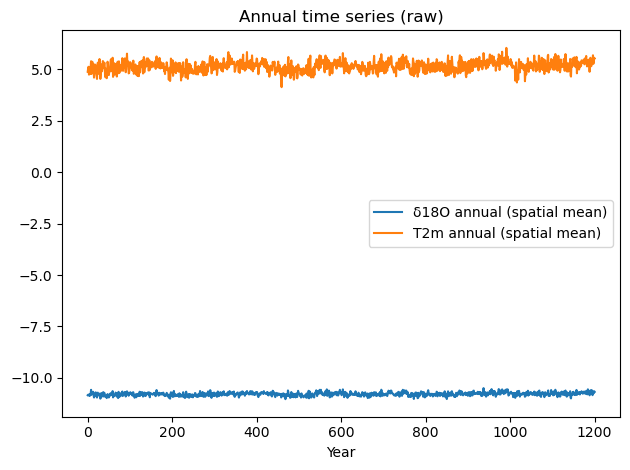

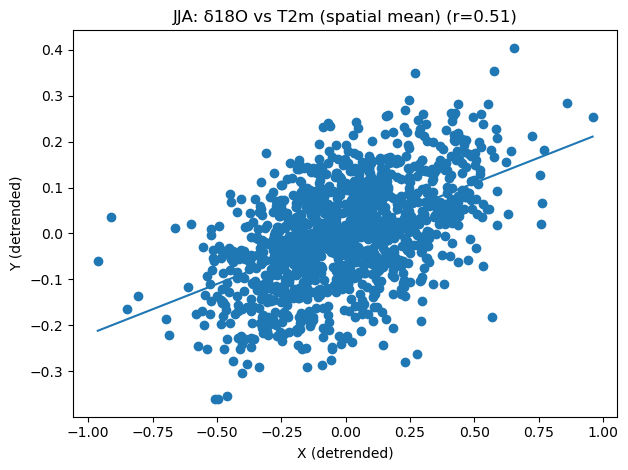

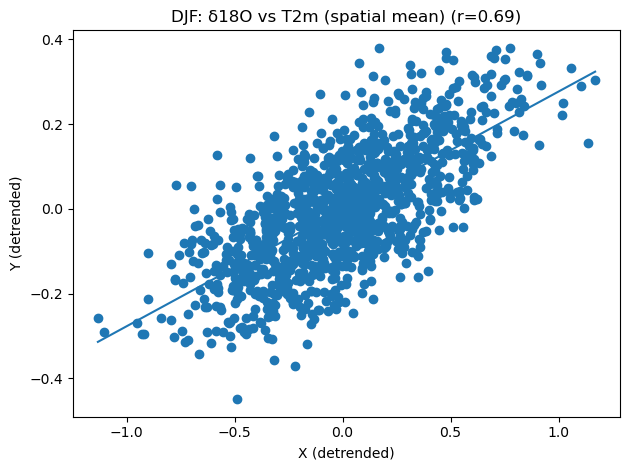

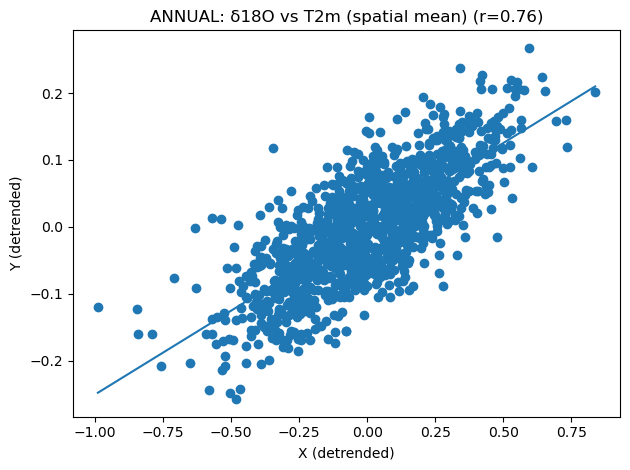

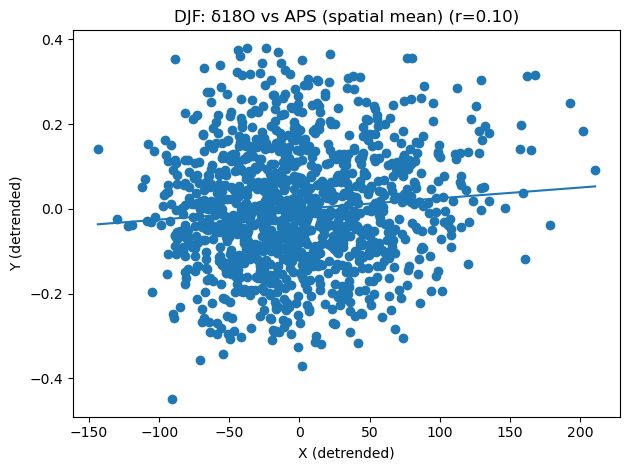

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def detrend(x):
    x = np.asarray(x).astype(float)
    t = np.arange(len(x))
    m, b = np.polyfit(t, x, 1)
    return x - (m*t + b)

def to_ts(a):
    """
    Convert a variable to a 1D time series.
    If a is (time, y, x) -> spatial mean over (y, x)
    If a is already (time,) -> return as is
    """
    a = np.asarray(a)
    if a.ndim == 1:
        return a
    if a.ndim == 3:
        return np.nanmean(a, axis=(1,2))
    raise ValueError(f"Unsupported shape {a.shape}")

def relate(x, y, title):
    x = to_ts(x); y = to_ts(y)
    xdt = detrend(x)
    ydt = detrend(y)
    r = np.corrcoef(xdt, ydt)[0, 1]
    reg = linregress(xdt, ydt)
    print(f"{title}: r={r:.3f}, slope={reg.slope:.4f}")

    plt.figure()
    plt.scatter(xdt, ydt)
    xx = np.linspace(np.min(xdt), np.max(xdt), 50)
    plt.plot(xx, reg.slope*xx + reg.intercept)
    plt.title(f"{title} (r={r:.2f})")
    plt.xlabel("X (detrended)")
    plt.ylabel("Y (detrended)")
    plt.tight_layout()

years = d18o["years"]

# Convert everything to 1D time series
d18o_ann = to_ts(d18o["annual"])
d18o_jja = to_ts(d18o["jja"])
d18o_djf = to_ts(d18o["djf"])

t2m_ann = to_ts(t2m["annual"])
t2m_jja = to_ts(t2m["jja"])
t2m_djf = to_ts(t2m["djf"])

aps_ann = to_ts(aps["annual"])
aps_jja = to_ts(aps["jja"])
aps_djf = to_ts(aps["djf"])

# 1) Plot annual time series
plt.figure()
plt.plot(years, d18o_ann, label="δ18O annual (spatial mean)")
plt.plot(years, t2m_ann, label="T2m annual (spatial mean)")
plt.title("Annual time series (raw)")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()

# 2) δ18O vs T2m (seasonal + annual)
relate(t2m_jja, d18o_jja, "JJA: δ18O vs T2m (spatial mean)")
relate(t2m_djf, d18o_djf, "DJF: δ18O vs T2m (spatial mean)")
relate(t2m_ann, d18o_ann, "ANNUAL: δ18O vs T2m (spatial mean)")

# 3) Winter circulation link (DJF)
relate(aps_djf, d18o_djf, "DJF: δ18O vs APS (spatial mean)")

plt.show()


### EOF of winter APS (DJF)
Is Greenland δ¹⁸O correlated to the main modes of atmospheric circulation in the North Atlantic?
EOF1 of APS (DJF) over North Atlantic

In [19]:
# ---------- helper ----------
def detrend(x):
    x = np.asarray(x).astype(float)
    t = np.arange(len(x))
    m, b = np.polyfit(t, x, 1)
    return x - (m*t + b)

# ---------- APS DJF field ----------
aps_djf = aps["djf"]  # shape: (time, y, x)
print("APS DJF shape:", aps_djf.shape)

# Remove temporal mean (anomalies)
aps_anom = aps_djf - np.nanmean(aps_djf, axis=0)

# Flatten space → (time, space)
T, Y, X = aps_anom.shape
M = aps_anom.reshape(T, Y * X)

# Handle NaNs safely
M = np.nan_to_num(M)

# ---------- EOF analysis ----------
pca = PCA(n_components=1)
pc1 = pca.fit_transform(M).squeeze()     # NAO-like index
eof1 = pca.components_[0].reshape(Y, X)  # spatial pattern

print("Explained variance EOF1:", pca.explained_variance_ratio_[0])


APS DJF shape: (1201, 48, 96)
Explained variance EOF1: 0.27306530469512064


In [20]:
# Greenland δ18O DJF (already spatial mean)
d18o_djf = np.nanmean(d18o["djf"], axis=(1,2))

# Detrend
pc1_dt   = detrend(pc1)
d18o_dt  = detrend(d18o_djf)

# Correlation + regression
r = np.corrcoef(pc1_dt, d18o_dt)[0,1]
reg = linregress(pc1_dt, d18o_dt)

print(f"DJF δ18O vs EOF1(APS): r = {r:.3f}, slope = {reg.slope:.4f}")

DJF δ18O vs EOF1(APS): r = 0.068, slope = 0.0000


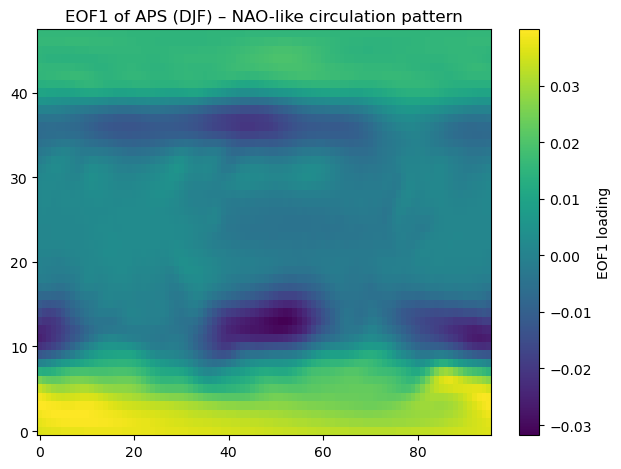

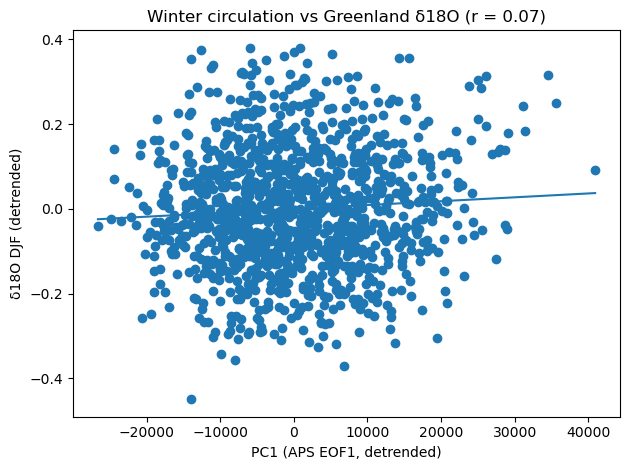

In [22]:
plt.figure()
plt.imshow(eof1, origin="lower", aspect="auto")
plt.colorbar(label="EOF1 loading")
plt.title("EOF1 of APS (DJF) – NAO-like circulation pattern")
plt.tight_layout()

plt.figure()
plt.scatter(pc1_dt, d18o_dt)
xx = np.linspace(pc1_dt.min(), pc1_dt.max(), 50)
plt.plot(xx, reg.slope*xx + reg.intercept)

plt.xlabel("PC1 (APS EOF1, detrended)")
plt.ylabel("δ18O DJF (detrended)")
plt.title(f"Winter circulation vs Greenland δ18O (r = {r:.2f})")
plt.tight_layout()
plt.show()
